In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict

In [2]:
class OSPFRouter:
    def __init__(self, router_id):
        self.router_id = router_id
        self.link_state_db = {}
        self.neighbors = {}
        self.routing_table = {}
        self.shortest_path_tree = {}
    
    def add_neighbor(self, neighbor_id, cost):
        self.neighbors[neighbor_id] = cost
    
    def update_lsdb(self, router_id, neighbors):
        self.link_state_db[router_id] = neighbors.copy()
    
    def dijkstra(self):
        distances = {router: float('inf') for router in self.link_state_db.keys()}
        distances[self.router_id] = 0
        next_hops = {}
        visited = set()
        pq = [(0, self.router_id, self.router_id)]
        
        while pq:
            current_dist, current_router, first_hop = heapq.heappop(pq)
            
            if current_router in visited:
                continue
            
            visited.add(current_router)
            
            if current_router != self.router_id:
                next_hops[current_router] = first_hop
            
            if current_router in self.link_state_db:
                for neighbor, cost in self.link_state_db[current_router].items():
                    if neighbor not in visited:
                        new_dist = current_dist + cost
                        
                        if new_dist < distances[neighbor]:
                            distances[neighbor] = new_dist
                            new_first_hop = first_hop if current_router != self.router_id else neighbor
                            heapq.heappush(pq, (new_dist, neighbor, new_first_hop))
        
        self.routing_table = {}
        for dest, dist in distances.items():
            if dest != self.router_id and dist != float('inf'):
                self.routing_table[dest] = (dist, next_hops.get(dest, dest))
        
        self.shortest_path_tree = distances
    
    def display_routing_table(self):
        print(f"\nRouting Table for Router {self.router_id}:")
        print("-" * 50)
        print(f"{'Destination':<15} {'Cost':<10} {'Next Hop':<15}")
        print("-" * 50)
        for dest in sorted(self.routing_table.keys()):
            cost, next_hop = self.routing_table[dest]
            print(f"{dest:<15} {cost:<10} {next_hop:<15}")
        print("-" * 50)
    
    def display_spt(self):
        print(f"\nShortest Path Tree for Router {self.router_id}:")
        print("-" * 40)
        print(f"{'Router':<15} {'Distance':<15}")
        print("-" * 40)
        for router in sorted(self.shortest_path_tree.keys()):
            dist = self.shortest_path_tree[router]
            if dist == float('inf'):
                dist_str = "Unreachable"
            else:
                dist_str = str(dist)
            print(f"{router:<15} {dist_str:<15}")
        print("-" * 40)

In [3]:
def simulate_ospf(topology):
    routers = {}
    
    for router_id in topology.keys():
        routers[router_id] = OSPFRouter(router_id)
    
    for router_id, neighbors in topology.items():
        for neighbor_id, cost in neighbors.items():
            routers[router_id].add_neighbor(neighbor_id, cost)
    
    print("Starting OSPF Simulation...")
    print("=" * 60)
    print("\nPhase 1: Link State Advertisement (LSA) Exchange")
    print("-" * 60)
    
    for router_id, router in routers.items():
        print(f"Router {router_id} advertising its links: {router.neighbors}")
    
    for router_id, router in routers.items():
        for other_id, other_router in routers.items():
            router.update_lsdb(other_id, other_router.neighbors)
    
    print("\nPhase 2: Computing Shortest Path Tree using Dijkstra's Algorithm")
    print("-" * 60)
    
    for router_id, router in routers.items():
        router.dijkstra()
        print(f"Router {router_id} computed its SPT")
    
    print("\n" + "=" * 60)
    print("SHORTEST PATH TREES")
    print("=" * 60)
    
    for router_id in sorted(routers.keys()):
        routers[router_id].display_spt()
    
    print("\n" + "=" * 60)
    print("FINAL ROUTING TABLES")
    print("=" * 60)
    
    for router_id in sorted(routers.keys()):
        routers[router_id].display_routing_table()
    
    return routers

In [4]:
def visualize_topology(topology):
    G = nx.Graph()
    
    for router, neighbors in topology.items():
        for neighbor, cost in neighbors.items():
            G.add_edge(router, neighbor, weight=cost)
    
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 8))
    
    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', 
                          node_size=1500, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)
    
    plt.title("OSPF Network Topology", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
def visualize_spt(router, topology):
    G = nx.Graph()
    
    for r, neighbors in topology.items():
        for neighbor, cost in neighbors.items():
            G.add_edge(r, neighbor, weight=cost)
    
    spt_edges = []
    for dest, (cost, next_hop) in router.routing_table.items():
        current = dest
        visited = set()
        while current != router.router_id and current not in visited:
            visited.add(current)
            for r_id, r in topology.items():
                if r_id == current:
                    for neighbor in r.keys():
                        if neighbor in router.routing_table:
                            if router.routing_table[neighbor][0] < router.routing_table[current][0]:
                                spt_edges.append((neighbor, current))
                                current = neighbor
                                break
                        elif neighbor == router.router_id:
                            spt_edges.append((router.router_id, current))
                            current = router.router_id
                            break
                    break
    
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 8))
    
    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', 
                          node_size=1500, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    all_edges = list(G.edges())
    nx.draw_networkx_edges(G, pos, all_edges, width=1, alpha=0.3, style='dashed')
    
    if spt_edges:
        nx.draw_networkx_edges(G, pos, spt_edges, width=3, alpha=0.8, edge_color='red')
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)
    
    plt.title(f"Shortest Path Tree for Router {router.router_id}", 
             fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

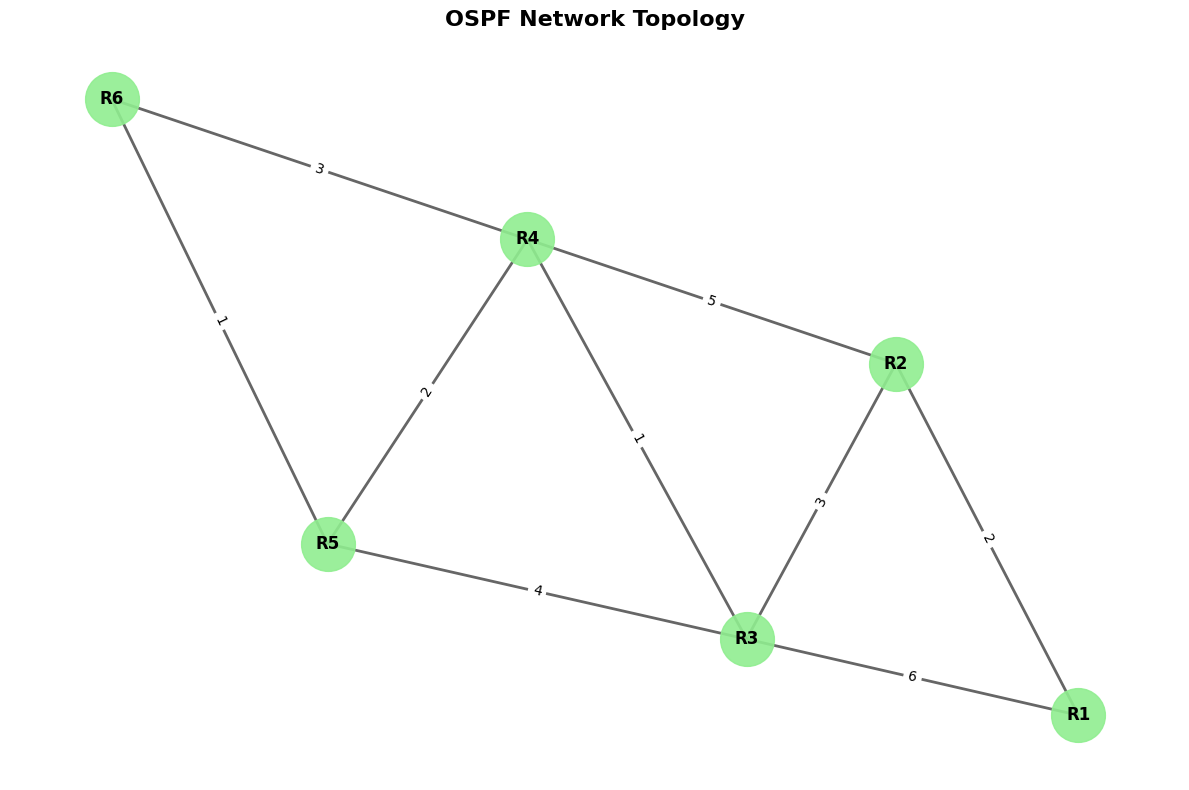

In [6]:
topology = {
    'R1': {'R2': 2, 'R3': 6},
    'R2': {'R1': 2, 'R3': 3, 'R4': 5},
    'R3': {'R1': 6, 'R2': 3, 'R4': 1, 'R5': 4},
    'R4': {'R2': 5, 'R3': 1, 'R5': 2, 'R6': 3},
    'R5': {'R3': 4, 'R4': 2, 'R6': 1},
    'R6': {'R4': 3, 'R5': 1}
}

visualize_topology(topology)

In [7]:
routers = simulate_ospf(topology)

Starting OSPF Simulation...

Phase 1: Link State Advertisement (LSA) Exchange
------------------------------------------------------------
Router R1 advertising its links: {'R2': 2, 'R3': 6}
Router R2 advertising its links: {'R1': 2, 'R3': 3, 'R4': 5}
Router R3 advertising its links: {'R1': 6, 'R2': 3, 'R4': 1, 'R5': 4}
Router R4 advertising its links: {'R2': 5, 'R3': 1, 'R5': 2, 'R6': 3}
Router R5 advertising its links: {'R3': 4, 'R4': 2, 'R6': 1}
Router R6 advertising its links: {'R4': 3, 'R5': 1}

Phase 2: Computing Shortest Path Tree using Dijkstra's Algorithm
------------------------------------------------------------
Router R1 computed its SPT
Router R2 computed its SPT
Router R3 computed its SPT
Router R4 computed its SPT
Router R5 computed its SPT
Router R6 computed its SPT

SHORTEST PATH TREES

Shortest Path Tree for Router R1:
----------------------------------------
Router          Distance       
----------------------------------------
R1              0              
R2  

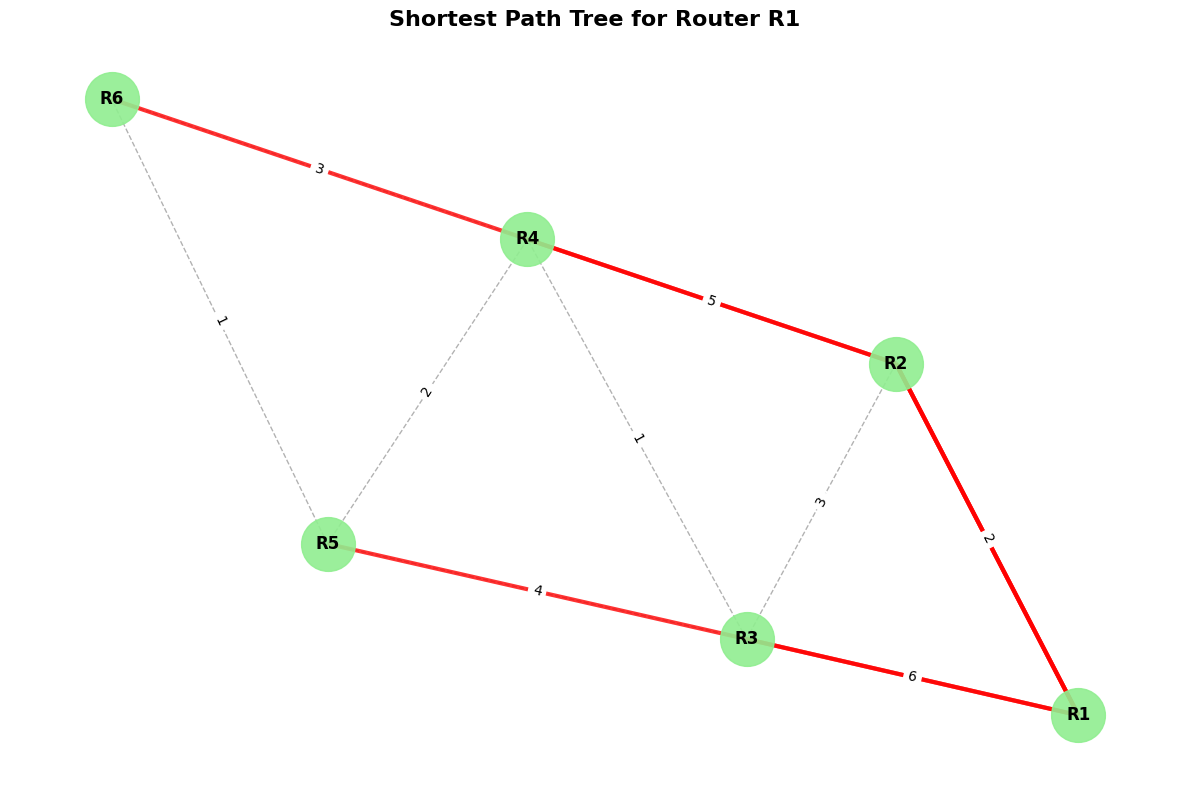

In [8]:
visualize_spt(routers['R1'], topology)